Implementation of manual LSTM in Python Notebook

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import Data

In [40]:
#data 
path = r'./names.csv'
data = pd.read_csv(path, on_bad_lines='skip')

#get names from the dataset
data['Names'] = data['Names']

#get first 10000 names
data = np.array(data['Names'][:10000]).reshape(-1,1)

#covert the names to lower case
data = [x.lower() for x in data[:,0]]
data = np.array(data).reshape(-1,1)

In [41]:
# Example of random names
print(data[np.random.choice(data.shape[0], 10, replace=False)])

[['cy']
 ['nydia']
 ['kazu']
 ['rylee']
 ['carrick']
 ['abel']
 ['sukey']
 ['yachi']
 ['omega']
 ['lilah']]


Make every name the same length

In [42]:
#to store the transform data
transform_data = np.copy(data)

#find the max length name
max_length = 0
for index in range(len(data)):
    max_length = max(max_length,len(data[index,0]))

#make every name of max length by adding '.'
for index in range(len(data)):
    length = (max_length - len(data[index,0]))
    string = '.'*length
    transform_data[index,0] = ''.join([transform_data[index,0],string])

In [43]:
# Newly transformed data
print(transform_data[np.random.choice(transform_data.shape[0], 10, replace=False)])

[['karston.....']
 ['york........']
 ['trude.......']
 ['glynis......']
 ['rina........']
 ['sorley......']
 ['teleza......']
 ['powa........']
 ['liz.........']
 ['valentina...']]


Store names in vocabulary and map chars to ids and vice versa

In [44]:
#to store the vocabulary
vocab = list()
for name in transform_data[:,0]:
    vocab.extend(list(name))

vocab = set(vocab)
vocab_size = len(vocab)

# Maps the characters to ids and vice versa
char_id = dict()
id_char = dict()

for i,char in enumerate(vocab):
    char_id[char] = i
    id_char[i] = char

Split the data into batches and one hot encode the data

In [45]:
#to store the train dataset
train_dataset = []
batch_size = 20

# Split the data into batches
for i in range(len(transform_data)-batch_size+1):
    start = i*batch_size
    end = start+batch_size
    #batch data
    batches = transform_data[start:end]
    if(len(batches)!=batch_size):
        break
    #convert each char of each name of batch data into one hot encoding
    char_list = []
    for k in range(len(batches[0][0])):
        batch_dataset = np.zeros([batch_size,len(vocab)])
        for j in range(batch_size):
            name = batches[j][0]
            char_index = char_id[name[k]]
            batch_dataset[j,char_index] = 1.0
        #store the ith char's one hot representation of each name in batches
        char_list.append(batch_dataset)
    #store each char's of every name in batch dataset into train_dataset
    train_dataset.append(char_list)

Train the model

In [47]:
from LSTM import new_LSTM

# Initialize the training parameters
input = 200
hidden = 250
output= vocab_size
learning_rate = 0.005
iterations= 9001
batch_size=20
# create a new model
lstm = new_LSTM(input,hidden,output,learning_rate)
# create a new optimizer
#initalize the parameters
params = lstm.init_params()
#initialize the V and S parameters for Adam Optimizer
V_dict = lstm.init_V(params)
S_dict = lstm.init_S(params)
#generate the random embeddings
embeddings = np.random.normal(0,0.01,(len(vocab),input))

# Store the loss and accuracy for each step
loss_list = []
acc_list = []


for step in range(iterations):
    # Get dataset in batches
    index = step%len(train_dataset)
    batches = train_dataset[index]
    # Get embeddings, lstm_dict, activation_dict, cell_dict, output_dict
    lstm_dict,activation_dict,cell_dict,embed_dict,output_dict = lstm.forward(batches,params,embeddings)
    # Calculate the loss and accuracy
    loss,acc = lstm.calculate_loss_accuracy(batches,output_dict)
    # Use backpropagation to calculate the derivatives and embedding error
    derivatives,embedding_error = lstm.backward(batches,embed_dict,lstm_dict,activation_dict,cell_dict,output_dict,params)
    # Update the parameters and get V and S parameters for Adam Optimizer
    params,V_dict,S_dict = lstm.update_parameters(params,derivatives,V_dict,S_dict,step, learning_rate, 0.9, 0.999)
    # Update the embeddings and get the new embeddings
    embeddings = lstm.update_embeddings(embeddings,embedding_error,batches)
    # Update the loss and accuracy
    loss_list.append(loss)
    acc_list.append(acc)
    
    # Print the loss and accuracy for every 1000 steps
    if(step%1000==0):
        print("-----------------------------------")
        print(f'Step = {step}\nLoss = {round(loss,2)}\nAccuracy = {round(acc*100,2)}')
        print("-----------------------------------")



-----------------------------------
Step = 0
Loss = 48.23
Accuracy = 0.91
-----------------------------------
-----------------------------------
Step = 1000
Loss = 16.77
Accuracy = 65.0
-----------------------------------
-----------------------------------
Step = 2000
Loss = 16.34
Accuracy = 62.73
-----------------------------------
-----------------------------------
Step = 3000
Loss = 20.46
Accuracy = 55.91
-----------------------------------
-----------------------------------
Step = 4000
Loss = 17.01
Accuracy = 69.55
-----------------------------------
-----------------------------------
Step = 5000
Loss = 10.74
Accuracy = 76.82
-----------------------------------
-----------------------------------
Step = 6000
Loss = 11.35
Accuracy = 77.27
-----------------------------------
-----------------------------------
Step = 7000
Loss = 13.78
Accuracy = 71.36
-----------------------------------
-----------------------------------
Step = 8000
Loss = 12.72
Accuracy = 72.73
---------------

Evaluate the Loss and Accuracy

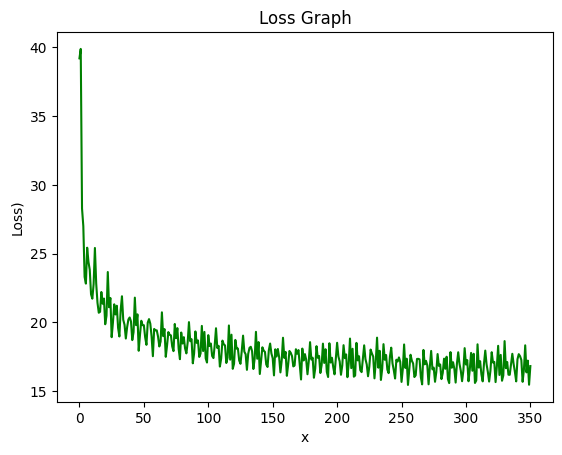

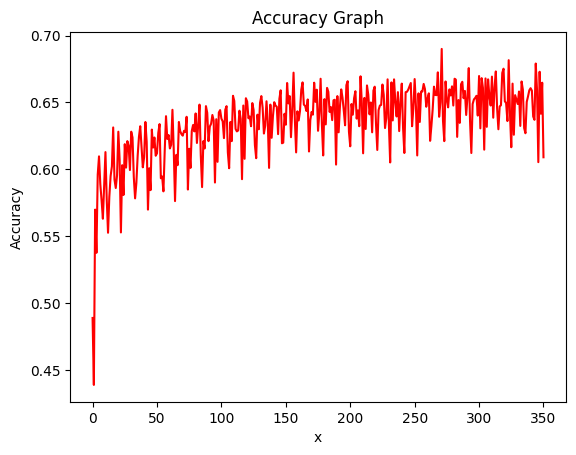

In [ ]:
avg_loss = list()
avg_acc = list()
i = 0
while(i<len(loss_list)):
    avg_loss.append(np.mean(loss_list[i:i+20]))
    avg_acc.append(np.mean(acc_list[i:i+20]))
    i += 20

plt.plot(list(range(len(avg_loss))),avg_loss, color='green')
plt.xlabel("x")
plt.ylabel("Loss)")
plt.title("Loss Graph")
plt.show()

plt.plot(list(range(len(avg_acc))),avg_acc, color='red')
plt.xlabel("x")
plt.ylabel("Accuracy")
plt.title("Accuracy Graph")
plt.show()    

Make Predictions and Compare Results

In [ ]:
predictions = []
for i in range(20):
    # Initialize activation and cell matrix
    a0 = np.zeros([1, hidden],dtype=np.float32)
    c0 = np.zeros([1, hidden],dtype=np.float32)
    # Initialize name
    name = ''
    # Create batches
    batches = np.zeros([1,vocab_size])
    # Get randomized starting index
    index = np.random.randint(0,vocab_size, 1)[0]
    # Set the first batch
    batches[0,index] = 1.0
    # Append the first character to the name
    name += id_char[index]
    # Store charcter from id_char
    char = id_char[index]
    # Loop through until the . is predicted
    while(char != '.'):
        # Get the embeddings
        batches = lstm.get_embeddings(batches, embeddings)
        # Get activations from new lstm cell
        a_dict, c_dict, activations = lstm.new_cell(batches, a0, c0, params)
        # Put through output cell
        output = lstm.new_output_cell(a_dict, params)
        # Get prediction for charactera
        pred = np.random.choice(vocab_size, 1, p=output[0])[0]
        # Add character to name
        name += id_char[pred]
        char = id_char[pred]
        # Set the next batch
        batches = np.zeros([1,vocab_size])
        batches[0,pred] = 1.0
        # Set the next activation and cell matrix
        a0 = a_dict
        c0 = c_dict

    # Append the name to the predictions
    predictions.append(name)

    # Print the predictions
    for i in range(len(predictions)):
        print(predictions[i])

 gwoomel.
 gwoomel.
ginane.
 gwoomel.
ginane.
windy.
 gwoomel.
ginane.
windy.
tyrey.
 gwoomel.
ginane.
windy.
tyrey.
.
 gwoomel.
ginane.
windy.
tyrey.
.
vaaghan.
 gwoomel.
ginane.
windy.
tyrey.
.
vaaghan.
abste.
 gwoomel.
ginane.
windy.
tyrey.
.
vaaghan.
abste.
ra.
 gwoomel.
ginane.
windy.
tyrey.
.
vaaghan.
abste.
ra.
eliza.
 gwoomel.
ginane.
windy.
tyrey.
.
vaaghan.
abste.
ra.
eliza.
qianes.
 gwoomel.
ginane.
windy.
tyrey.
.
vaaghan.
abste.
ra.
eliza.
qianes.
kat.
 gwoomel.
ginane.
windy.
tyrey.
.
vaaghan.
abste.
ra.
eliza.
qianes.
kat.
xrosena.
 gwoomel.
ginane.
windy.
tyrey.
.
vaaghan.
abste.
ra.
eliza.
qianes.
kat.
xrosena.
winoses.
 gwoomel.
ginane.
windy.
tyrey.
.
vaaghan.
abste.
ra.
eliza.
qianes.
kat.
xrosena.
winoses.
trenil.
 gwoomel.
ginane.
windy.
tyrey.
.
vaaghan.
abste.
ra.
eliza.
qianes.
kat.
xrosena.
winoses.
trenil.
brougia.
 gwoomel.
ginane.
windy.
tyrey.
.
vaaghan.
abste.
ra.
eliza.
qianes.
kat.
xrosena.
winoses.
trenil.
brougia.
.
 gwoomel.
ginane.
windy.
tyrey.
.
v